In [1]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint

# reading docfiles
import docx2txt

#nltk
import nltk

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('german')
stop_words.extend(['ja', 'ne', 'ok', 'okay', 'genau', 'also', 'mhm'])

In [3]:
os.chdir('input/app_v2')

path_v1 = ("C:\\Users\\vanandkuma\\Documents\\projects\\sentiment_analysis\\input\\app_v2")

In [4]:
files = []
for file in os.listdir(path_v1):
    if file.endswith('.docx'):
        files.append(file)

In [5]:
pooled_doc = []
for i in range(len(files)):
    text = docx2txt.process(files[i])
    pooled_doc.append(text) 

In [7]:
df = []
for i in range(len(pooled_doc)):
    sentence = nltk.tokenize.sent_tokenize(pooled_doc[i])
    for i in range(len(sentence)):
        df.append(sentence[i])

In [8]:
for i in range(len(df)):
    df[i] = df[i].replace('\n', '')

In [9]:
#print(df)

In [10]:
df = pd.DataFrame(df, columns=['text'])

In [11]:
df = df.replace('I:','', regex=True)
df = df.replace('TN:','', regex=True)
df = df.replace('N:','', regex=True)
df = df.replace('ZN:','', regex=True)
df = df.replace('i:','', regex=True)
df = df.replace('T:','', regex=True)
df = df.replace('t:','', regex=True)

In [12]:
df['text_processed'] = \
df['text'].map(lambda x: re.sub('[,.!?]', '', x))

In [13]:
df['text_processed'] = \
df['text_processed'].map(lambda x: x.lower())

In [14]:
df.head()

,text,text_processed
0,Ja.,ja
1,"Ja, ich höre Sie ein bisschen schlecht.",ja ich höre sie ein bisschen schlecht
2,Das hallt so ein bisschen.,das hallt so ein bisschen
3,Oh!,oh
4,"Ok, ist es jetzt besser?",ok ist es jetzt besser


In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), 
                                             deacc = True))

In [16]:
data = df.text_processed.values.tolist()
data_words = list(sent_to_words(data))

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['ja']


In [18]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [20]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [21]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("de_core_news_sm", disable = ['parser', 'ner'])

In [22]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[[]]


In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[]]


In [24]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[]]

In [25]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [26]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.041*"gut" + 0.019*"einfach" + 0.018*"schon" + 0.018*"machen" + '
  '0.015*"mal" + 0.013*"eigentlich" + 0.013*"ganz" + 0.013*"wirklich" + '
  '0.012*"irgendwie" + 0.012*"gehen"'),
 (1,
  '0.052*"halt" + 0.037*"sagen" + 0.034*"finden" + 0.028*"nochmal" + '
  '0.020*"vielleicht" + 0.017*"wissen" + 0.012*"bissch" + 0.011*"einfach" + '
  '0.010*"Fall" + 0.009*"Punkt"')]


In [27]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.236266871460867

Coherence Score:  0.46977052528225394


In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.148042  0.0       1        1  61.054595
1     -0.148042  0.0       2        1  38.945405, topic_info=        Term        Freq       Total Category  logprob  loglift
56      halt  302.000000  302.000000  Default  30.0000  30.0000
191    sagen  221.000000  221.000000  Default  29.0000  29.0000
3        gut  374.000000  374.000000  Default  28.0000  28.0000
127   finden  206.000000  206.000000  Default  27.0000  27.0000
128  nochmal  165.000000  165.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
186   vorher   19.202371   21.800842   Topic2  -5.7103   0.8161
194    Punkt   50.971055   80.531920   Topic2  -4.7340   0.4856
269    isbar   19.249710   22.975424   Topic2  -5.7078   0.7661
19   einfach   61.352270  230.339588   Topic2  -4.5487  -0.3799
35       app   19.929401  108.742180   Topic2  -5.6731  -0.7538

[107 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
148       1  0.983983  Beispiel
148       2  0.015375  Beispiel
365       1  0.082658    Chance
365       2  0.909240    Chance
310       1  0.017391      Fall
...     ...       ...       ...
166       2  0.014323   wichtig
111       1  0.986213  wirklich
111       2  0.008429  wirklich
54        1  0.009990    wissen
54        2  0.989019    wissen

[150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=1, 
                                                        limit=6, 
                                                        step=1)

In [31]:
os.chdir("C:\\Users\\vanandkuma\\Documents\\projects\\sentiment_analysis")

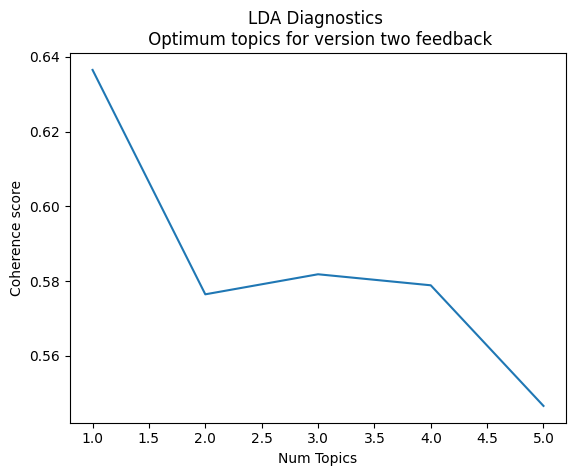

In [33]:
# Show graph
limit=6; start=1; step=1;
x = range(start, limit, step)
plt.title("LDA Diagnostics \n Optimum topics for version two feedback")
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.savefig('output/app_v2_lda_topic_coherence.png')

In [35]:
pyLDAvis.save_html(vis, 'output/ldavis_app_v2.html')